In [1]:
# Steps required
# Create a data pipeline that reads in image from file directory and is able to pass the image to model for training

# Design of U-Net backbone

# Design of CBAM attention model

# Design of U-Net integrated with CBAM and the skip connections

# Design of loss functions

# Design of visualisation to evaluate model
    # 1. Generate ground truth after a certain number of epochs
    # 2. Training curves
    # 3. Grad-CAM mask (mentioned in CBAM paper)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import os
import sys

from cbam_unet import *
sys.path.append(os.path.join(os.getcwd(), '..', 'helpers'))
from visualisation_helpers import *

%load_ext autoreload
%autoreload 2

In [2]:
print(tf.version.VERSION)

2.15.0


# 0. Read in images and preprocess them
Source: https://www.tensorflow.org/tutorials/load_data/images

- Step 1: Specify batch size and image dimensions (Specifying the dimension results in Tensorflow cropping the image for you)
- Step 2: Split the dataset into train and validation split
- Step 3: Normalise the pixel values

In [3]:
# Step 1

batch_size = 1 # change back to 8 later
img_height = 400
img_width = 400
num_channels = 3

In [4]:
# Step 2
# Use a seed of 1 to ensure reproducibility of results
# Use ImageDataGenerator instead

seed = 1
imgs_dir = os.path.join(os.path.dirname(os.getcwd()), 'datasets/train/image')
labels_dir = os.path.join(os.path.dirname(os.getcwd()), 'datasets/train/groundtruth')

# Equivalent to x_train
train_imgs_ds = tf.keras.utils.image_dataset_from_directory(
  imgs_dir,
  validation_split=0.1,
  subset="training",
  seed=seed,
  labels=None,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Equivalent to x_val
val_imgs_ds = tf.keras.utils.image_dataset_from_directory(
  imgs_dir,
  validation_split=0.1,
  subset="validation",
  seed=seed,
  labels=None,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Equivalent to y_train
train_gt_ds = tf.keras.utils.image_dataset_from_directory(
  labels_dir,
  color_mode="grayscale",
  validation_split=0.1,
  subset="training",
  labels=None,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Equivalent to y_val
val_gt_ds = tf.keras.utils.image_dataset_from_directory(
  labels_dir,
  color_mode="grayscale",
  validation_split=0.1,
  subset="validation",
  seed=seed,
  labels=None,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100 files belonging to 1 classes.
Using 90 files for training.
Found 100 files belonging to 1 classes.
Using 10 files for validation.
Found 100 files belonging to 1 classes.
Using 90 files for training.
Found 100 files belonging to 1 classes.
Using 10 files for validation.


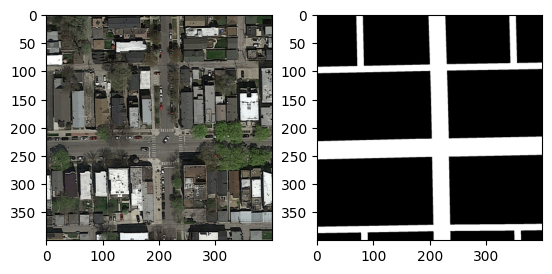

In [6]:
_imgs = []
_gts = []

for images in train_imgs_ds.take(1):
    for i in range(1):
        _imgs.append(images[i].numpy().astype("uint8"))

for gts in train_gt_ds.take(1):
    for i in range(1):
        _gts.append(gts[i].numpy().astype("uint8"))

fig, axs = plt.subplots(1,2)
#fig, axs = plt.subplots(2,2, figsize=(6, 8))

axs[0].imshow(_imgs[0])
axs[1].imshow(_gts[0], cmap="gray")
                   
#axs[1][0].imshow(_imgs[1])
#axs[1][1].imshow(_gts[1], cmap="gray")

In [7]:
# Step 3
# No need to normalise for groundtruths since they will only contain two possible pixel values, black or white
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_imgs_ds = train_imgs_ds.map(lambda x: (normalization_layer(x)))
train_gt_ds = train_gt_ds.map(lambda x: (normalization_layer(x)))

In [8]:
sample_img_batch = next(iter(train_imgs_ds))
sample_image = sample_img_batch[0]

print(f'Sample image, min. pixel value: {np.min(sample_image)}, max. pixel value: {np.max(sample_image)}')

Sample image, min. pixel value: 0.0, max. pixel value: 1.0


# 1. Instantiate model and run on a sample

In [10]:
'''
input_shape = (img_height, img_width, num_channels)
cbam_unet_model = CBAM_UNet(input_shape)
# cbam_unet_model.build(input_shape) # input shape: (None, 400, 400, 3)
cbam_unet_model.summary()
'''

input_shape = (None, img_height, img_width, num_channels)
cbam_unet_model = CBAM_UNet(input_shape[1:])
cbam_unet_model.build(input_shape) # input shape: (None, 400, 400, 3)
cbam_unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 400, 400, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 re_lu (ReLU)                (None, 400, 400, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 400, 400, 64)         36928     ['re_lu[0][0]']               
                                                                                              

In [11]:
sample_img = train_imgs_ds.take(1)
sample_gt = train_gt_ds.take(1)

In [13]:
sample_output = None

for img in sample_img:
    sample_output = cbam_unet_model(img)

In [15]:
sample_gt_ = None

for gt in sample_gt:
    sample_gt_ = gt

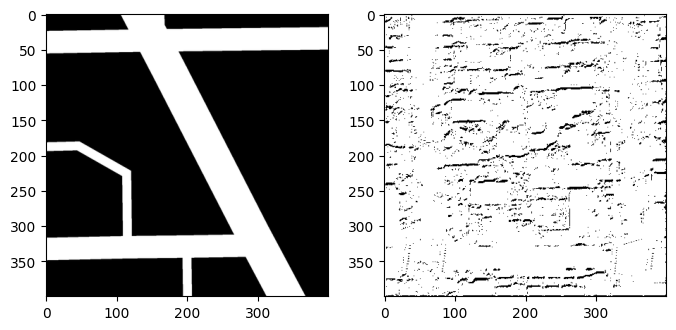

In [23]:
# Visualise predicted segmentation map and ground truth 
concatenate_seg_maps(sample_gt_.numpy()[0], sample_output.numpy()[0])

In [25]:
sample_img_ = None

for img in sample_img:
    sample_img_ = img

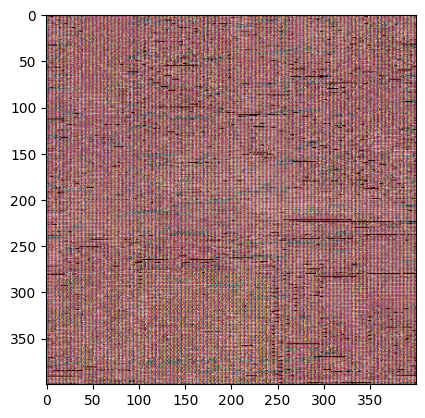

In [29]:
colour_mask = segmap_to_colourmask(400, 400, sample_output.numpy()[0])
overlayed_img = make_img_overlay(sample_img_.numpy()[0], colour_mask)
plt.imshow(overlayed_img)